In [27]:
%load_ext autoreload
%autoreload 2

%matplotlib inline
from overlap import *  # bad practice
from IPython.display import display

import pysal
from astropy.io import fits
from astropy.table import Table
from astropy import stats
import sklearn
from scipy.stats import gaussian_kde, ks_2samp
from scipy.interpolate import interp1d
from scipy import integrate 

import seaborn as sns
sns.set_context('poster')

from axial_ratio_comparison import cache_nsa, get_agn_catalog
from shared_utilities import plot_catalog, plot_catalog_overlap

### Load Data - NSA, DR7 Catalog, Heckman AGN catalog, Galaxy Zoo 2

Descriptions and download links for the DR7 catalog:
* http://home.strw.leidenuniv.nl/~jarle/SDSS/
* https://wwwmpa.mpa-garching.mpg.de/SDSS/

In [28]:
heckman = get_heckman_catalog(heckman_loc='/data/repos/find_agn/catalogs/sdss_dr7_radiosources.cat')
galaxy_zoo = pd.read_csv('/data/galaxy_zoo/gz2/subjects/gz2_hart16.csv')

/Data/repos/find_agn/overlap.py:11: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df = pd.read_table(heckman_loc, sep=r"\s*")
/data/anaconda3/envs/py36/lib/python3.6/site-packages/pandas/io/parsers.py:2138: FutureWarning: split() requires a non-empty pattern match.
  yield pat.split(line.strip())
/data/anaconda3/envs/py36/lib/python3.6/site-packages/pandas/io/parsers.py:2140: FutureWarning: split() requires a non-empty pattern match.
  yield pat.split(line.strip())


In [29]:
def cache_galloway(table_loc, csv_loc):
    galloway = Table.read(table_loc)
    for col in galloway.colnames:
        galloway.rename_column(col, col.lower())
    galloway.rename_column('u-r color', 'u-r_color')
    galloway.rename_column('velocity dispersion', 'velocity_dispersion')
    galloway.rename_column('velocity dispersion err', 'velocity_dispersion_err')
    galloway.rename_column('sdss dr7 objid', 'dr7_objid')
    galloway.rename_column('stellar mass', 'stellar_mass')
    # Table converter silently murders large ints when converting to pandas - rounding error ruins ids
    # this would be a good pull request to help out with?
    galloway['dr7_objid'] = list(map(lambda x: str(x), galloway['dr7_objid']))
    describe_bpt_class = {
        1: 'star-forming',
        0: 'undetermined',
        2: 'composite',
        4: 'liner',
        3: 'agn'}
    galloway['bpt_class'] = list(map(lambda x: describe_bpt_class[x], galloway['bpt_class']))
    galloway.to_pandas().to_csv(csv_loc, index=False)

In [30]:
table_loc = '/data/repos/find_agn/catalogs/galloway_et_al_2015_data.fits'
csv_loc = '/data/repos/find_agn/catalogs/galloway_et_al_2015_data.csv'
new_galloway = False
if new_galloway:
    cache_galloway(table_loc, csv_loc)
galloway = pd.read_csv(csv_loc, dtype={'dr7_objid': str, 'n_bar': int})

In [31]:
new_dr7 = False
source_loc = '/data/galaxy_zoo/decals/catalogs/gal_info_dr7_v5_2.fit'
cache_loc = '/data/galaxy_zoo/decals/catalogs/gal_info_dr7_v5_2_cache.csv'

In [32]:
def cache_dr7(source_loc, cache_loc):
    dr7 = Table(fits.getdata(source_loc))
    for col in dr7.colnames:
        dr7.rename_column(col, col.lower())
    bands = ['g', 'r', 'i']
    mag_cols = ['kcor_mag_{}'.format(band) for band in bands]
    for n in range(len(bands)):
        mag_col = mag_cols[n]
        dr7[mag_col] = [dr7[row]['kcor_mag'][n] for row in range(len(dr7))]
    useful_columns = ['ra','dec', 'z', 'release'] + mag_cols
    dr7[useful_columns].write(target_loc)

In [33]:
if new_dr7:
    cache_dr7(source_loc, cache_loc)
dr7 = pd.read_csv(cache_loc)

In [34]:
new_nsa = False
nsa_loc = '/data/galaxy_zoo/decals/catalogs/nsa_v1_0_1.fits'
nsa_cache_loc = '/data/galaxy_zoo/decals/catalogs/nsa_v1_0_1_cached.csv'
if new_nsa:
    useful_nsa_columns = [
    'ra',
    'dec',
    'mag',
    'petro_ba50',
    'petro_phi50',
    'petro_ba90',
    'petro_phi90',
    'elpetro_mass',
    'elpetro_phi',
#     'elpetro_flux_r',
    'elpetro_theta',
    ]
    useful_nsa_columns = list(map(lambda x: x.upper(), useful_nsa_columns))
    nsa = cache_nsa(nsa_loc, nsa_cache_loc, useful_nsa_columns)

In [35]:
nsa = pd.read_csv(nsa_cache_loc)

In [36]:
def enforce_physical_ra_limits(catalog):
    physical_catalog = catalog[(catalog['dec'] < 90.) & (catalog['dec'] > -90.)]
    print('Catalog reduced to {} from {} galaxies'.format(len(physical_catalog), len(catalog)))
    return physical_catalog

In [37]:
nsa = enforce_physical_ra_limits(nsa)
dr7 = enforce_physical_ra_limits(dr7)

Catalog reduced to 641409 from 641409 galaxies
Catalog reduced to 927551 from 927552 galaxies


## Match all catalogs to build useful features

###  Check how well DR7 and NSA match (65%)

This isn't necessary, it just helps check where any mismatch occurs

In [38]:
dr7_and_nsa, dr7_no_nsa = match_galaxies_to_catalog_pandas(dr7, nsa)
print('Galaxies matched: {}. Galaxies missed: {}.'.format(len(dr7_and_nsa), len(dr7_no_nsa)))

Galaxies matched: 587420. Galaxies missed: 340131.


Therefore DR7 and NSA are quite bad matches!

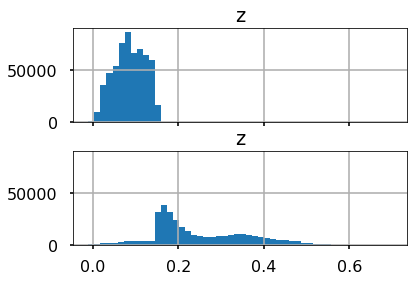

In [39]:
fig, axes = plt.subplots(2, sharex=True, sharey=True)
dr7_and_nsa.hist('z', bins=50, ax=axes[0])
a = dr7_no_nsa.hist('z', bins=50, ax=axes[1])

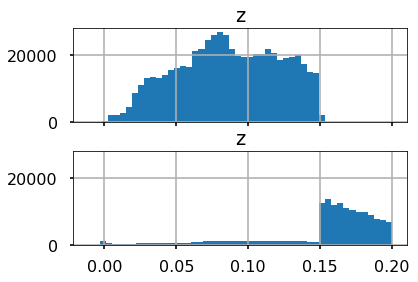

In [40]:
fig, axes = plt.subplots(2, sharex=True, sharey=True)
dr7_and_nsa[dr7_and_nsa['z'] < 0.2].hist('z', bins=50, ax=axes[0])
a = dr7_no_nsa[dr7_no_nsa['z'] < 0.2].hist('z', bins=50, ax=axes[1])

The mismatch is almost completely due to redshift - NSA only goes to z = 0.15, but DR7 goes to z = 0.6. That's okay - we're only looking for fairly nearby galaxies with detectable bars

### Check how Heckman and DR7 match (perfectly)

In [41]:
heckman_and_dr7, heckman_no_dr7 = match_galaxies_to_catalog_pandas(heckman, dr7)
print('Galaxies matched: {}. Galaxies missed: {}.'.format(len(heckman_and_dr7), len(heckman_no_dr7)))

Galaxies matched: 18286. Galaxies missed: 0.


Perfect - all Heckman radio sources are in DR7 , as expected - Heckman used DR7 to crossmatch for sources

### Check how Galloway and DR7 match

In [42]:
galloway_and_dr7, galloway_no_dr7 = match_galaxies_to_catalog_pandas(galloway, dr7)
print('Galaxies matched: {}. Galaxies missed: {}.'.format(len(galloway_and_dr7), len(galloway_no_dr7)))

Galaxies matched: 19756. Galaxies missed: 0.


Perfect - all Galloway sources in DR7, as expected

### Check how Galloway and NSA match

In [43]:
galloway_and_nsa, galloway_no_nsa = match_galaxies_to_catalog_pandas(galloway, nsa)
print('Galaxies matched: {}. Galaxies missed: {}.'.format(len(galloway_and_nsa), len(galloway_no_nsa)))

Galaxies matched: 19261. Galaxies missed: 495.


Almost perfectly- a few percent dropped. I should check why it's not perfect, but for now, let's continue.

### Check how NSA and Galaxy Zoo match (90%)

In [44]:
nsa_and_gz, nsa_no_gz = match_galaxies_to_catalog_pandas(galaxy_zoo, nsa)
print('Galaxies matched: {}. Galaxies missed: {}.'.format(len(nsa_and_gz), len(nsa_no_gz)))

Galaxies matched: 218759. Galaxies missed: 20936.


Yep, 90% match. 10% loss is most likely from radius cut.

### Check how DR7-NSA-GZ subset match to Heckman (badly - 25%!)

In [45]:
heckman_gz, heckman_only = match_galaxies_to_catalog_pandas(heckman, nsa_and_gz)
print('LERG remaining: {} of {}'.format(heckman_gz['lerg'].sum(), heckman['lerg'].sum()))
print('Galaxies matched: {}. Galaxies missed: {}.'.format(len(heckman_gz), len(heckman_only['lerg'])))

LERG remaining: 2565 of 9863
Galaxies matched: 5051. Galaxies missed: 13235.


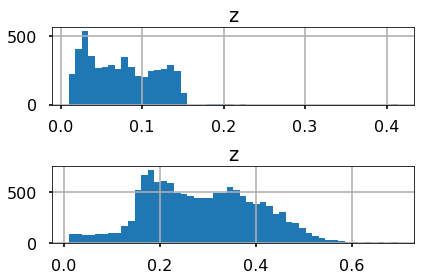

In [46]:
fig, axes = plt.subplots(2)
heckman_gz.hist('z', bins=50, ax=axes[0])
heckman_only.hist('z', bins=50, ax=axes[1])
fig.tight_layout()

The big drop here is because of the DR7-NSA mismatch in z. Most, but not all, of the missed galaxies are at z > 0.15. This is because the NSA catalog is limited to 0.15 but DR7 is not - see above

In [47]:
heckman_gz, heckman_only = match_galaxies_to_catalog_pandas(heckman[heckman['z'] < 0.15], nsa_and_gz)
print('LERG remaining: {} of {}'.format(heckman_gz['lerg'].sum(), heckman['lerg'].sum()))
print('Galaxies matched: {}. Galaxies missed: {}.'.format(len(heckman_gz), len(heckman_only['lerg'])))

/Data/repos/find_agn/shared_utilities.py:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  galaxies['best_match'] = best_match_catalog_index
/Data/repos/find_agn/shared_utilities.py:97: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  galaxies['sky_separation'] = sky_separation.to(u.arcsec).value


LERG remaining: 2558 of 9863
Galaxies matched: 5040. Galaxies missed: 1145.


After accounting for z, the match is 85% complete. The remainder is most likely additional GZ cuts on spatial extent, magnitude etc.

### Let's do it - link Heckman to DR7, GZ to NSA, then link both

In [48]:
heckman_dr7, heckman_only = match_galaxies_to_catalog_pandas(heckman, dr7)
print('LERG remaining: {} of {}'.format(heckman_dr7['lerg'].sum(), heckman['lerg'].sum()))
print('Galaxies matched: {}. Galaxies missed: {}.'.format(len(heckman_dr7), len(heckman)))

LERG remaining: 9863 of 9863
Galaxies matched: 18286. Galaxies missed: 18286.


In [49]:
gz_nsa, gz_only = match_galaxies_to_catalog_pandas(galaxy_zoo, nsa)
print('Galaxies matched: {}. Galaxies missed: {}.'.format(len(gz_nsa), len(gz_only)))

Galaxies matched: 218759. Galaxies missed: 20936.


In [50]:
gz_heckman, heckman_no_gz = match_galaxies_to_catalog_pandas(heckman_dr7, gz_nsa)
print('LERG remaining: {} of {}'.format(gz_heckman['lerg'].sum(), heckman_dr7['lerg'].sum()))
print('Galaxies remaining: {} of {}'.format(len(gz_heckman), len(heckman_no_gz)))

LERG remaining: 2565 of 9863
Galaxies remaining: 5051 of 13235


And let's also link Galloway to DR7 and NSA for a BPT-selected comparison catalog

In [51]:
galloway_dr7, galloway_only = match_galaxies_to_catalog_pandas(galloway, dr7)
print('Galaxies matched: {}. Galaxies missed: {}.'.format(len(galloway_dr7), len(galloway_only)))

Galaxies matched: 19756. Galaxies missed: 0.


In [52]:
galloway_dr7_nsa, galloway_only = match_galaxies_to_catalog_pandas(galloway_dr7, nsa)
print('Galaxies matched: {}. Galaxies missed: {}.'.format(len(galloway_dr7_nsa), len(galloway_only)))
print(galloway_dr7_nsa['bpt_class'].value_counts())

Galaxies matched: 19261. Galaxies missed: 495.
star-forming    10975
undetermined     3518
composite        2796
liner            1300
agn               672
Name: bpt_class, dtype: int64


### Todo: What's the original distributions in mass, colour, z for each catalog?

## Do Science

Make a new 'agn_type' column so Heckman's data is easier to work with

In [53]:
def get_agn_type(series):
    if series['herg'] == 1:
        return 'herg'
    elif series['lerg'] == 1:
        return 'lerg'
    else:
        return 'star-forming'

In [54]:
galaxies = gz_heckman.copy()
galaxies['p_bar'] = galaxies['t03_bar_a06_bar_debiased']  # use debiased value or no?
galaxies = galaxies.dropna(subset=['p_bar', 'petro_ba90'])
galaxies['agn_type'] = galaxies.apply(get_agn_type, axis=1)

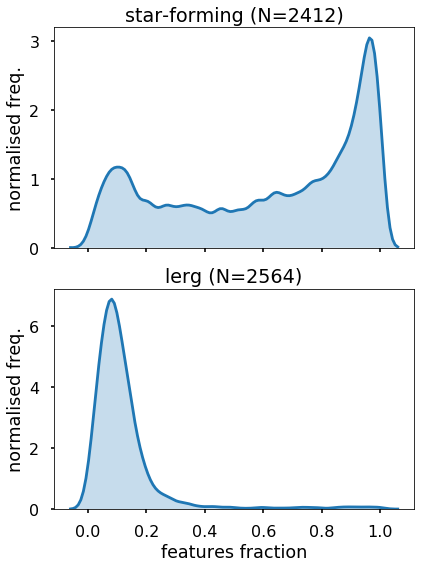

In [55]:
agn_types = ['lerg', 'star-forming']
lerg = galaxies[galaxies['agn_type'] == 'lerg']
sf = galaxies[galaxies['agn_type'] == 'star-forming']
fig, axes = plt.subplots(2, figsize=(6, 8), sharex=True)
ax = sns.kdeplot(data=sf['t01_smooth_or_features_a02_features_or_disk_fraction'], ax=axes[0], shade=True, bw=0.02)
ax.legend_.remove()
ax.set_title('star-forming (N={})'.format(len(sf)))
ax.set_ylabel('normalised freq.')
ax = sns.kdeplot(data=lerg['t01_smooth_or_features_a02_features_or_disk_fraction'], ax=axes[1], shade=True, bw=0.02)
ax.set_title('lerg (N={})'.format(len(lerg)))
ax.set_xlabel('features fraction')
ax.set_ylabel('normalised freq.')
ax.legend_.remove()
fig.tight_layout()

Galaxies with LERGs, generally, are WAY less featured than star-forming galaxies. I think this might be a selection effect. Most galaxies are smooth, and so most AGN are smooth. But star-forming galaxies are generally featured. We can't select smooth non-AGN galaxies because we require radio sources. This would be more informative checked against the full GZ population.

** This whole analysis is really only looking at the featured tail (N < 100) of the LERG population (N = 2500) **

I should plot a bunch of small random thumbnails of each to get a sense for what the different populations look like

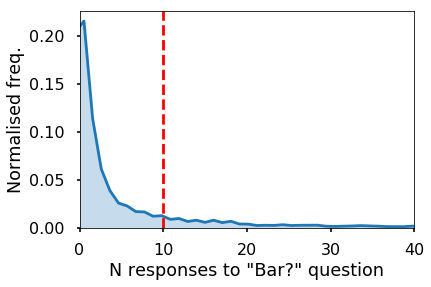

In [56]:
galaxies['bar_answers'] = galaxies['t03_bar_a06_bar_count'] + galaxies['t03_bar_a06_bar_count']
ax = sns.kdeplot(data=galaxies['bar_answers'], shade=True, legend=False)
ax.set_xlabel('N responses to "Bar?" question')
ax.set_ylabel('Normalised freq.')
_ = ax.set_xlim([0, 40])
ax.axvline(10, color='r', linestyle='--')

Text(0,0.5,'Normalised freq.')

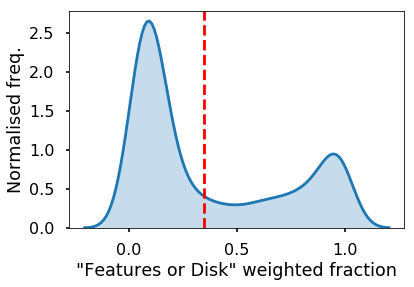

In [57]:
ax = sns.kdeplot(data=galaxies['t01_smooth_or_features_a02_features_or_disk_weighted_fraction'], shade=True, legend=False)
ax.axvline(0.35, color='r', linestyle='--')
ax.set_xlabel('"Features or Disk" weighted fraction')
ax.set_ylabel('Normalised freq.')

** When we filter for galaxies with p_bar as defined by Mel is we lose 85% of the LERG population - because they're rarely featured **

In [58]:
def filter_for_pbar(df):
    # apply filters - keep only well-measured galaxies
    print('initial count: ', len(df))
    # > 10 answer 'is there a sign of a bar?
    df = df[df['t03_bar_a06_bar_count'] + df['t03_bar_a06_bar_count'] > 10]
    print('with 10 bar answers: ', len(df))
    # p(features or disk) > 0.35?
    # not clear if these should be debiased
    df = df[df['t01_smooth_or_features_a02_features_or_disk_weighted_fraction'] > 0.35] 
    print('with features fraction > 0.35:', len(df))
    # p(not edge on) > 0.6?
    # not clear if these should be debiased
    df = df[df['t02_edgeon_a05_no_weighted_fraction'] > 0.6] 
    print('with edge-on fraction > 0.6:', len(df))
    return df

In [59]:
galaxies = filter_for_pbar(galaxies)

initial count:  5050
with 10 bar answers:  810
with features fraction > 0.35: 796
with edge-on fraction > 0.6: 764


Only 15% have valid pbar measurements, as defined by Mel. This is mostly because quite few galaxies have > 10 answers to 'is there a bar?'. That's because about 2/3rds of people answer 'smooth' to 'featured or smooth?'. But why should we exclude 'smooth'? Isn't 'smooth' an indicator of the absence of a bar? Also remember that all galaxies are star-forming.

What do we know about AGN in galaxies which are smooth v featured?

### Investigate how agn type correlates with bar fraction

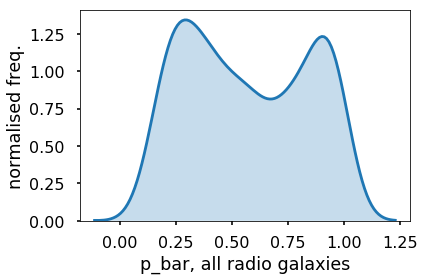

In [60]:
fig, ax = plt.subplots()
ax = sns.kdeplot(data=galaxies['p_bar'], ax=ax, shade=True)
ax.set_xlabel('p_bar, all radio galaxies')
ax.set_ylabel('normalised freq.')
ax.legend_.remove()
fig.tight_layout()

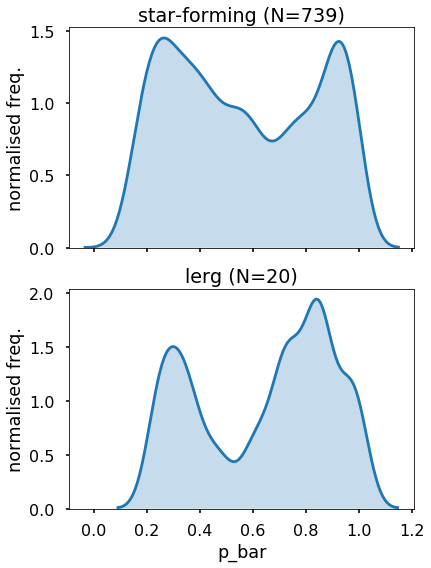

In [61]:
agn_types = ['lerg', 'star-forming']
lerg = galaxies[galaxies['agn_type'] == 'lerg']
sf = galaxies[galaxies['agn_type'] == 'star-forming']
fig, axes = plt.subplots(2, figsize=(6, 8), sharex=True)
ax = sns.kdeplot(data=sf['p_bar'], ax=axes[0], shade=True, bw=0.05)
ax.legend_.remove()
ax.set_title('star-forming (N={})'.format(len(sf)))
ax.set_ylabel('normalised freq.')
ax = sns.kdeplot(data=lerg['p_bar'], ax=axes[1], shade=True, bw=0.05)
ax.set_title('lerg (N={})'.format(len(lerg)))
ax.set_xlabel('p_bar')
ax.set_ylabel('normalised freq.')
ax.legend_.remove()
fig.tight_layout()

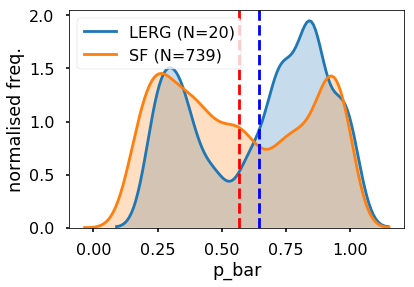

In [62]:
ax = sns.kdeplot(data=lerg['p_bar'], shade=True, bw=0.05, legend=False)
ax = sns.kdeplot(data=sf['p_bar'], shade=True, bw=0.05, legend=False)
ax.set_xlabel('p_bar')
ax.set_ylabel('normalised freq.')
ax.legend([
    'LERG (N={})'.format(len(lerg)), 
    'SF (N={})'.format(len(sf))
])
ax.axvline(lerg['p_bar'].mean(), color='b', linestyle='--')
ax.axvline(sf['p_bar'].mean(), color='r', linestyle='--')

Both show a bimodal distribution in pbar, as with galaxies in general. LERGs have a particular clear distribution, and are slightly more likely to be barred than SF-radio galaxies.

### Repeat the pbar analysis for Mel's catalog

In [63]:
opt_galaxies = galloway_dr7_nsa.copy()
opt_agn_types = set(opt_galaxies['bpt_class'].unique()) - {'undetermined'}

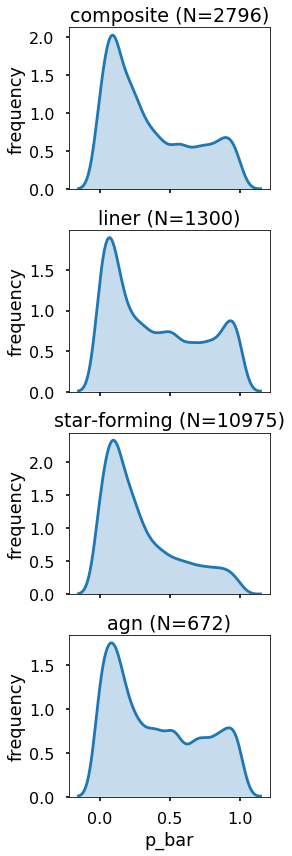

In [64]:
fig, axes = plt.subplots(len(opt_agn_types), figsize=(4, 12), sharex=True)
for agn_type_index, agn_type in enumerate(opt_agn_types):
    selected = opt_galaxies[opt_galaxies['bpt_class'] == agn_type]
    ax = sns.kdeplot(data=selected['p_bar'], ax=axes[agn_type_index], shade=True, bw=0.05, legend=False)
    ax.set_title('{} (N={})'.format(agn_type, len(selected)))
    ax.set_ylabel('frequency')
ax.set_xlabel('p_bar')
fig.tight_layout()

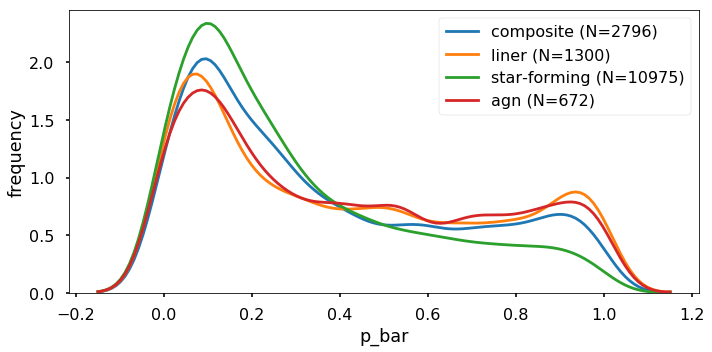

In [65]:
legend = []
fig, ax = plt.subplots(figsize=(10, 5))
for agn_type_index, agn_type in enumerate(opt_agn_types):
    selected = opt_galaxies[opt_galaxies['bpt_class'] == agn_type]
    ax = sns.kdeplot(data=selected['p_bar'], shade=False, bw=0.05, legend=False)
    legend.append('{} (N={})'.format(agn_type, len(selected)))
    ax.set_ylabel('frequency')
ax.set_xlabel('p_bar')
ax.legend(legend)
fig.tight_layout()

### Control for mass and colour

What's the general distribution of mass and colour?

In [66]:
def define_galaxy_bulk_properties(df):
    df = df.copy()
    df['g-r'] = df['elpetro_mag_g'] - df['elpetro_mag_r']
    df['u-r'] = df['elpetro_mag_u'] - df['elpetro_mag_r']
    df['mass'] = df['elpetro_mass']
    df = df[df['mass'] > 1] # avoid div0 errors
    df['log_mass'] = np.log10(df['elpetro_mass'])
    return df

In [67]:
galaxies = define_galaxy_bulk_properties(galaxies)

I thought that galaxies were supposed to be bimodel in colour. That's not really true with the u-r fluxes of my sample. Maybe I should follow the literature and use mag colours.

In [68]:
def plot_color_mag_diagram(df, ax=None):
    ax = sns.kdeplot(data=df['log_mass'], data2=df['g-r'], bw=0.02, ax=ax)
    ax.set_ylabel('g-r')
    ax.set_xlabel('log mass')
    plt.gcf().tight_layout()
    return ax

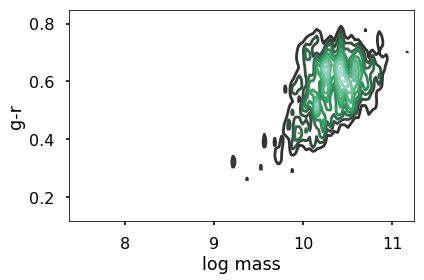

In [69]:
plot_color_mag_diagram(galaxies)

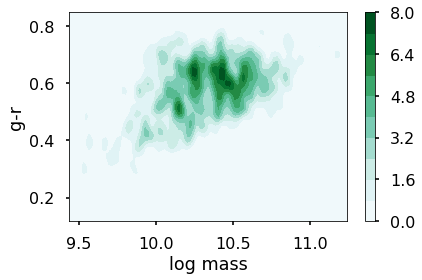

In [70]:
selected_galaxies = galaxies[(galaxies['log_mass'] > 9.5) &  (galaxies['g-r'] < 1.0) & (galaxies['g-r'] > 0.)]
ax = sns.kdeplot(data=selected_galaxies['log_mass'], data2=selected_galaxies['g-r'], shade=True, cbar=True, bw=0.02)
ax.set_ylabel('g-r')
ax.set_xlabel('log mass')
plt.gcf().tight_layout()

### How are the mass and colour distributions different for LERG and SF?

In [71]:
def compare_bulk_properties(sample_a, sample_b, show_points, bw_mass, bw_colour, bw_redshift, names):
    fig, axes = plt.subplots(3, 1, figsize=(8, 9))

    ax = sns.kdeplot(data=sample_a['log_mass'], shade=True, bw=bw_mass[0], ax=axes[0], legend=False)
    ax = sns.kdeplot(data=sample_b['log_mass'], shade=True, bw=bw_mass[1], ax=axes[0], legend=False)
    if show_points:
        for val in sample_b['log_mass']:
            ax.axvline(val, color='orange', linestyle='--', linewidth=1.0)
    ax.set_title('mass')
    ax.legend(names)

    ax = sns.kdeplot(data=sample_a['g-r'], shade=True, bw=bw_colour[0], ax=axes[1], legend=False)
    ax = sns.kdeplot(data=sample_b['g-r'], shade=True, bw=bw_colour[1], ax=axes[1], legend=False)
    if show_points:
        for val in sample_b['g-r']:
            ax.axvline(val, color='orange', linestyle='--', linewidth=1.0)
    ax.legend(names)
    ax.set_title('colour')

    ax = sns.kdeplot(data=sample_a['z'], shade=True, bw=bw_redshift[0], ax=axes[2], legend=False)
    ax = sns.kdeplot(data=sample_b['z'], shade=True, bw=bw_redshift[1], ax=axes[2], legend=False)
    if show_points:
        for val in sample_b['z']:
            ax.axvline(val, color='orange', linestyle='--', linewidth=1.0)
    ax.legend(names)
    ax.set_title('redshift')
    fig.tight_layout()

In [72]:
sf = galaxies[galaxies['agn_type'] == 'star-forming']
lerg = galaxies[galaxies['agn_type'] == 'lerg']

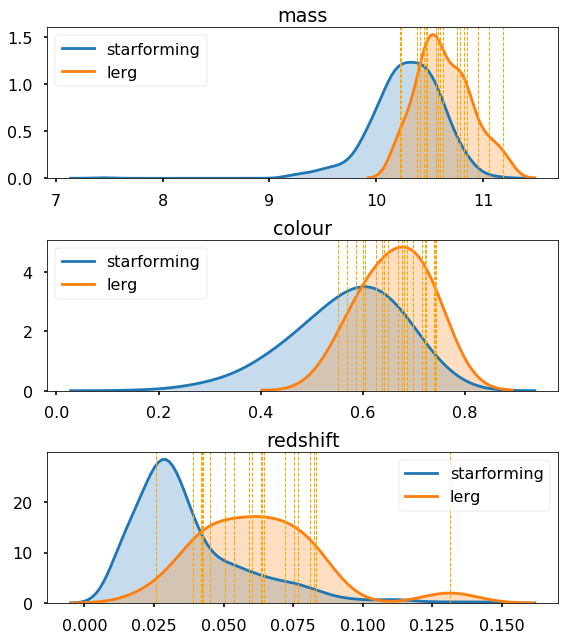

In [73]:
compare_bulk_properties(sf, lerg, True, (0.1, 0.1), (0.05, 0.05), (0.005, 0.01), ['starforming', 'lerg'])

### Compare bar-ness for a mass-matched sample

In [74]:
help(pysal.Kernel)

Help on class Kernel in module pysal.weights.Distance:

class Kernel(pysal.weights.weights.W)
 |  Spatial weights based on kernel functions.
 |  
 |  Parameters
 |  ----------
 |  
 |  data        : array
 |                (n,k) or KDTree where KDtree.data is array (n,k)
 |                n observations on k characteristics used to measure
 |                distances between the n objects
 |  bandwidth   : float
 |                or array-like (optional)
 |                the bandwidth :math:`h_i` for the kernel.
 |  fixed       : binary
 |                If true then :math:`h_i=h \forall i`. If false then
 |                bandwidth is adaptive across observations.
 |  k           : int
 |                the number of nearest neighbors to use for determining
 |                bandwidth. For fixed bandwidth, :math:`h_i=max(dknn) \forall i`
 |                where :math:`dknn` is a vector of k-nearest neighbor
 |                distances (the distance to the kth nearest neighbor for eac

In [75]:
help(pysal.esda.smoothing.Kernel_Smoother)

Help on class Kernel_Smoother in module pysal.esda.smoothing:

class Kernel_Smoother(_Spatial_Smoother)
 |  Kernal smoothing
 |  
 |  Parameters
 |  ----------
 |  e           : array (n, 1)
 |                event variable measured across n spatial units
 |  b           : array (n, 1)
 |                population at risk variable measured across n spatial units
 |  w           : Kernel weights instance
 |  
 |  Attributes
 |  ----------
 |  r           : array (n, 1)
 |                rate values from spatial rate smoothing
 |  
 |  Examples
 |  --------
 |  
 |  Creating an array including event values for 6 regions
 |  
 |  >>> e = np.array([10, 1, 3, 4, 2, 5])
 |  
 |  Creating another array including population-at-risk values for the 6 regions
 |  
 |  >>> b = np.array([100, 15, 20, 20, 80, 90])
 |  
 |  Creating a list containing geographic coordinates of the 6 regions' centroids
 |  
 |  >>> points=[(10, 10), (20, 10), (40, 10), (15, 20), (30, 20), (30, 30)]
 |  
 |  Creating a 

In [76]:

# def adaptive_smoothing(values):
#     kernel = pysal.Kernel(values)
#     if not kernel.id_order_set: 
#         kernel.id_order = range(0,len(values))
#     weights = np.ones(len(values)) * 5
#     rate = pysal.esda.smoothing.Kernel_Smoother(values, weights, kernel)
#     return rate.r

In [78]:
# values = np.random.rand(100, 1)
# smoothed_values = adaptive_smoothing(values)
# plt.plot(values, alpha=0.5)
# plt.plot(smoothed_values, alpha=0.5)

In [79]:
import rpy2
import rpy2.robjects as robjects
import rpy2.robjects.packages as rpackages

In [80]:


from rpy2.robjects.packages import importr
# import R's "base" package
base = importr('base')

# import R's "utils" package
utils = importr('utils')



In [81]:


# # R package names
# packnames = (
#     'ggplot2', 
#     'hexbin',
#     'scatterplot3d',
#     'spatstat',
#     'alphahull',
#     'dixon')

# # R vector of strings
# from rpy2.robjects.vectors import StrVector

# # Selectively install what needs to be install.
# # We are fancy, just because we can.
# names_to_install = list(filter(lambda x: ~rpackages.isinstalled(x), packnames))
# if len(names_to_install) > 0:
#     print(names_to_install)
#     utils.install_packages(StrVector(names_to_install))



In [82]:
spatstat = importr('spatstat', lib_loc='/home/walmsleym/Library/R/3.3/library')

In [89]:
help_doc = utils.help("adaptive.density")
print(str(help_doc))

R Help on ‘adaptive.density’adaptive.density           package:spatstat            R Documentation

_I_n_t_e_n_s_i_t_y _E_s_t_i_m_a_t_e _o_f _P_o_i_n_t _P_a_t_t_e_r_n _U_s_i_n_g _T_e_s_s_e_l_l_a_t_i_o_n

_D_e_s_c_r_i_p_t_i_o_n:

     Computes an adaptive estimate of the intensity function of a point
     pattern.

_U_s_a_g_e:

     adaptive.density(X, f = 0.1, ..., nrep = 1, verbose=TRUE)
     
_A_r_g_u_m_e_n_t_s:

       X: Point pattern dataset (object of class ‘"ppp"’).

       f: Fraction (between 0 and 1 inclusive) of the data points that
          will be removed from the data and used to determine a
          tessellation for the intensity estimate.

     ...: Arguments passed to ‘as.im’ determining the pixel resolution
          of the result.

    nrep: Number of independent repetitions of the randomised
          procedure.

 verbose: Logical value indicating whether to print progress reports.

_D_e_t

In [103]:
values = np.random.rand(10, 2)
x = robjects.FloatVector(values[0, :])
y = robjects.FloatVector(values[1, :])
x_range = robjects.FloatVector([0., 1.])
y_range = robjects.FloatVector([0., 1.])
# https://www.rdocumentation.org/packages/spatstat/versions/1.55-1/topics/ppp
values_point_pattern = spatstat.ppp(x, y, x_range, y_range)
r_estimate = spatstat.adaptive_density(values_point_pattern)
estimate = list(r_estimate)

Tiny
 
threshold:
 
returning
 
uniform
 
intensity
 
estimate




In [104]:
estimate

[R object with classes: ('matrix',) mapped to:
 <Matrix - Python:0x1119a4ac8 / R:0x1c2f8a0000>
 [2.000000, 2.000000, 2.000000, 2.000000, ..., 2.000000, 2.000000, 2.000000, 2.000000],
 R object with classes: ('integer',) mapped to:
 <IntVector - Python:0x1119a4b48 / R:0x7faab6008748>
 [128, 128],
 R object with classes: ('numeric',) mapped to:
 <FloatVector - Python:0x1119a4808 / R:0x7faab604a070>
 [0.000000, 1.000000],
 R object with classes: ('numeric',) mapped to:
 <FloatVector - Python:0x1119a4648 / R:0x7faab604a118>
 [0.000000, 1.000000],
 R object with classes: ('numeric',) mapped to:
 <FloatVector - Python:0x1119a40c8 / R:0x7faab32fdc48>
 [0.007812],
 R object with classes: ('numeric',) mapped to:
 <FloatVector - Python:0x1119a4448 / R:0x7faab6008598>
 [0.007812],
 R object with classes: ('numeric',) mapped to:
 <FloatVector - Python:0x1119a4188 / R:0x7faad77dcc00>
 [0.003906, 0.011719, 0.019531, 0.027344, ..., 0.972656, 0.980469, 0.988281, 0.996094],
 R object with classes: ('nu

In [106]:
print(estimate[0])

       [,1] [,2] [,3] [,4] [,5] [,6] [,7] [,8] [,9] [,10] [,11] [,12] [,13]
  [1,]    2    2    2    2    2    2    2    2    2     2     2     2     2
  [2,]    2    2    2    2    2    2    2    2    2     2     2     2     2
  [3,]    2    2    2    2    2    2    2    2    2     2     2     2     2
  [4,]    2    2    2    2    2    2    2    2    2     2     2     2     2
  [5,]    2    2    2    2    2    2    2    2    2     2     2     2     2
  [6,]    2    2    2    2    2    2    2    2    2     2     2     2     2
  [7,]    2    2    2    2    2    2    2    2    2     2     2     2     2
  [8,]    2    2    2    2    2    2    2    2    2     2     2     2     2
  [9,]    2    2    2    2    2    2    2    2    2     2     2     2     2
 [10,]    2    2    2    2    2    2    2    2    2     2     2     2     2
 [11,]    2    2    2    2    2    2    2    2    2     2     2     2     2
 [12,]    2    2    2    2    2    2    2    2    2     2     2     2     2
 [13,]    2 

In [ ]:
ggplot2 = importr('ggplot2', lib_loc='/home/walmsleym/Library/R/3.3/library')
pp = ggplot2.ggplot(np.ones(10))

In [ ]:
def match_distributions_between_catalogs(catalog_to_match, catalog_to_sample, value_col, limits, bw_tuple):
    catalog_to_match_kde = gaussian_kde(catalog_to_match[value_col], bw_method=bw_tuple[0])  # 0.15
    fig, ax = plt.subplots(1, figsize=(8, 3))
    sample_points = np.arange(limits[0], limits[1], 0.001)
    
    ax.plot(sample_points, catalog_to_match_kde.evaluate(sample_points))  # check it's working
    ax.set_xlim([limits[0], limits[1]])

    catalog_to_sample_kde = gaussian_kde(catalog_to_sample[value_col], bw_method=bw_tuple[1])  # it's important to fit the apparent distribution - normalise
    ax.plot(sample_points, catalog_to_sample_kde.evaluate(sample_points))  # check it's working
    
    ax.legend(['catalog to match', 'catalog to sample'])
    
    catalog_to_sample['resample_p'] = catalog_to_match_kde.evaluate(catalog_to_sample[value_col]) / catalog_to_sample_kde.evaluate(catalog_to_sample[value_col])
    catalog_to_sample['resample_p'] = catalog_to_sample['resample_p'] / catalog_to_sample['resample_p'].mean()
    catalog_sampled = catalog_to_sample.sample(len(catalog_to_match)*100, replace=True, weights=catalog_to_sample['resample_p'])
    
    return catalog_sampled

In [ ]:
sf_mass_matched = match_distributions_between_catalogs(lerg, sf, 'log_mass', (7, 13), (0.4, 0.15))

In [ ]:
sf_mass_color_matched = match_distributions_between_catalogs(lerg, sf_mass_matched, 'g-r', (0, 1), (0.4, 0.1))

In [ ]:
sf_matched = match_distributions_between_catalogs(lerg, sf_mass_color_matched, 'z', (0, 0.2), (0.4, 0.1))

In [ ]:
def visualise_match_quality(catalog_to_match, catalog_to_sample, sample, names, bw_mass, bw_colour, bw_redshift):
    fig, axes = plt.subplots(3, 1, figsize=(8, 9))
    lerg_mass_ax = sns.kdeplot(data=catalog_to_match['log_mass'], shade=True, bw=bw_mass, ax=axes[0], legend=False)
    ax = sns.kdeplot(data=catalog_to_sample['log_mass'], shade=True, bw=bw_mass, ax=axes[0], legend=False)
    ax = sns.kdeplot(data=sample['log_mass'], shade=True, bw=0.15, ax=axes[0], legend=False)
    lerg_mass_ax.set_title('mass')
    lerg_mass_ax.legend(names)

    ax = sns.kdeplot(data=catalog_to_match['g-r'], shade=True, bw=bw_colour, ax=axes[1], legend=False)
    ax = sns.kdeplot(data=catalog_to_sample['g-r'], shade=True, bw=bw_colour, ax=axes[1], legend=False)
    ax = sns.kdeplot(data=sample['g-r'], shade=True, bw=bw_colour, ax=axes[1], legend=False)
    ax.legend(names)
    ax.set_title('colour')

    ax = sns.kdeplot(data=catalog_to_match['z'], shade=True, bw=bw_redshift, ax=axes[2], legend=False)
    ax = sns.kdeplot(data=catalog_to_sample['z'], shade=True, bw=bw_redshift, ax=axes[2], legend=False)
    ax = sns.kdeplot(data=sample['z'], shade=True, bw=bw_redshift, ax=axes[2], legend=False)
    ax.legend(names)
    ax.set_title('redshift')
    
    fig.tight_layout()

In [ ]:
visualise_match_quality(lerg, sf, sf_matched, ['lerg', 'star-forming', 'sf matched'], 0.15, 0.05, 0.01)

In [ ]:
fig, ax = plt.subplots(figsize=(14, 6))
ax = sns.kdeplot(data=lerg['p_bar'], shade=True, bw=0.05, legend=False)
ax = sns.kdeplot(data=sf['p_bar'], shade=True, bw=0.05, legend=False)
ax = sns.kdeplot(data=sf_matched['p_bar'], shade=True, bw=0.05, legend=False)
ax.set_xlabel('p_bar')
ax.set_ylabel('normalised freq.')
ax.legend([
    'LERG (N={})'.format(len(lerg)), 
    'SF (N={}'.format(len(sf)),
    'SF-matched '.format(len(sf_matched))
])
ax.axvline(lerg['p_bar'].mean(), color='b', linestyle='--')
ax.axvline(sf['p_bar'].mean(), color='r', linestyle='--')
ax.axvline(sf_matched['p_bar'].mean(), color='g', linestyle='--')
fig.tight_layout()

### TODO: Statistically speaking, how similar are these distributions?

In [ ]:
def kde_to_cdf(kde, test_range, visualise=False):
    kde_sums = np.ones_like(test_range)
    for sample_n, sample in enumerate(test_range):
        kde_sums[sample_n] = kde.integrate_box_1d(low=test_range.min(), high=sample)
        cdf = interp1d(test_range, kde_sums)
    if visualise:
        plt.plot(test_range, kde_sums)
    return cdf

In [ ]:
def kuiper_test(sample, possible_parent, parent_bw=None, visualise=False, show_score=False):
    # see http://docs.astropy.org/en/stable/api/astropy.stats.kuiper.html#astropy.stats.kuiper
    # see http://www.aip.de/groups/soe/local/numres/bookcpdf/c14-3.pdf
    
    parent_kde = gaussian_kde(possible_parent, bw_method=parent_bw)
    test_range = np.linspace(0.0, 1.0, 5000)
    parent_cdf = kde_to_cdf(parent_kde, test_range)
    raw_score, p_of_score = stats.kuiper(data=sample, cdf=parent_cdf)
    
    if visualise:
        fig, (ax1, ax2) = plt.subplots(nrows=2)
        ax1.plot(test_range, parent_kde(test_range))
        ax2.plot(test_range, parent_cdf(test_range))
    if show_score:
        print('Kuiper Score: {:.3}. Prob. of that score or worse: {:.3}'.format(raw_score, p_of_score))
    return raw_score, p_of_score

In [ ]:
raw_value, p_value = kuiper_test(sample=lerg['p_bar'], possible_parent=sf_matched['p_bar'], parent_bw=0.15, show=True)

In [ ]:
# lerg_scores = []
# for n in range(100):
#    score, _ = kuiper_test(sample=lerg['p_bar'], possible_parent=sf_matched.sample(len(sf))['p_bar'], parent_bw=0.15, show_score=False, visualise=False)
#    lerg_scores.append(score)
expected_sf_scores = []
for n in range(100):
    score, _ = kuiper_test(sample=sf_matched.sample(len(lerg))['p_bar'], possible_parent=sf_matched.sample(len(sf))['p_bar'], parent_bw=0.15, show_score=False, visualise=False)
    expected_sf_scores.append(score)

In [ ]:
_ = plt.hist(expected_sf_scores, alpha=0.8)
_ = plt.hist(lerg_scores, alpha=0.8)
plt.legend(['Same (SF) dist', 'LERG dist'])
plt.xlabel('Kuiper score')
plt.ylabel('Count')
plt.tight_layout()

In [ ]:
# ks_sf_scores = []
for n in range(10000):
    score, _ = ks_2samp(sf_matched.sample(len(lerg))['p_bar'], sf_matched.sample(len(lerg))['p_bar'])
    ks_sf_scores.append(score)
# ks_lerg_scores = []
for n in range(10000):
    score, _ = ks_2samp(lerg['p_bar'], sf_matched.sample(len(lerg))['p_bar'])
    ks_lerg_scores.append(score)

In [ ]:
_ = plt.hist(ks_sf_scores, alpha=0.8)
_ = plt.hist(ks_lerg_scores, alpha=0.8)
plt.legend(['Same (SF) dist', 'LERG dist'])
plt.xlabel('KS score')
plt.ylabel('Count')
plt.tight_layout()

### Repeat the same approach for the BPT sample

In [ ]:
opt_galaxies = define_galaxy_bulk_properties(opt_galaxies)

In [ ]:
sf_opt = opt_galaxies[opt_galaxies['bpt_class'] == 'star-forming']
agn_opt = opt_galaxies[opt_galaxies['bpt_class'] == 'agn']
liner_opt = opt_galaxies[opt_galaxies['bpt_class'] == 'liner']

In [ ]:
fig, axes = plt.subplots(ncols=3, figsize=(10, 4), sharex=True, sharey=True)
ax = sns.kdeplot(data=sf_opt['log_mass'], data2=sf_opt['g-r'], bw=0.02, ax=axes[0], shade=True)
ax.set_title('star-forming')
ax = sns.kdeplot(data=agn_opt['log_mass'], data2=agn_opt['g-r'], bw=0.02, ax=axes[1], shade=True)
ax.set_title('agn')
ax = sns.kdeplot(data=liner_opt['log_mass'], data2=liner_opt['g-r'], bw=0.02, ax=axes[2], shade=True)
ax.set_title('liner')
ax.set_ylabel('g-r')
ax.set_xlabel('log mass')
ax.set_ylim([0, 1])
ax.set_xlim([8, 11])
fig.tight_layout()

In [ ]:
compare_bulk_properties(sf_opt, agn_opt, False, (0.1, 0.1), (0.05, 0.05), (0.005, 0.01), ['starforming', 'lerg'])

In [ ]:
sf_mass_matched = match_distributions_between_catalogs(agn_opt, sf_opt, 'log_mass', (8, 11), (0.4, 0.1))
sf_mass_color_matched = match_distributions_between_catalogs(agn_opt, sf_mass_matched, 'g-r', (0, 1), (0.4, 0.1))
sf_opt_matched = match_distributions_between_catalogs(agn_opt, sf_mass_color_matched, 'z', (0, 0.1), (0.4, 0.1))

In [ ]:
visualise_match_quality(agn_opt, sf_opt, sf_opt_matched, ['agn', 'starforming', 'sf matched'], 0.1, 0.05, 0.005)

In [ ]:
fig, ax = plt.subplots(figsize=(14, 6))
ax = sns.kdeplot(data=agn_opt['p_bar'], shade=True, bw=0.03, legend=False)
ax = sns.kdeplot(data=sf_opt['p_bar'], shade=True, bw=0.03, legend=False)
ax = sns.kdeplot(data=sf_opt_matched['p_bar'], shade=True, bw=0.03, legend=False)
ax.set_xlabel('p_bar')
ax.set_ylabel('normalised freq.')
ax.legend([
    'AGN (N={})'.format(len(agn_opt)), 
    'SF (N={}'.format(len(sf_opt)),
    'SF-matched '.format(len(sf_opt_matched))
])
ax.axvline(agn_opt['p_bar'].mean(), color='b', linestyle='--')
ax.axvline(sf_opt['p_bar'].mean(), color='r', linestyle='--')
ax.axvline(sf_opt_matched['p_bar'].mean(), color='g', linestyle='--')
fig.tight_layout()

In [ ]:
raw_value, p_value = kuiper_test(sample=agn_opt['p_bar'], possible_parent=sf_opt_matched['p_bar'].sample(len(sf_opt)), parent_bw=0.1, show=True)

In [ ]:
# agn_scores = []
for n in range(20):
    score, _ = kuiper_test(sample=agn_opt['p_bar'], possible_parent=sf_opt_matched.sample(len(sf_opt))['p_bar'], parent_bw=0.1, show_score=True, visualise=False)
    agn_scores.append(score)

In [ ]:
# expected_scores = []
for n in range(20):
    score, _ = kuiper_test(sample=sf_opt_matched.sample(672)['p_bar'], possible_parent=sf_opt_matched.sample(len(sf_opt))['p_bar'], parent_bw=0.1, show_score=True, visualise=False)
    expected_scores.append(score)

In [ ]:
_ = plt.hist(expected_scores)
_ = plt.hist(agn_scores)
plt.legend(['Same (SF-Opt) dist', 'AGN dist'])
plt.xlabel('Kuiper score')
plt.ylabel('Count')
plt.tight_layout()

In [ ]:
ks_sf_opt_scores = []
for n in range(50000):
    score, _ = ks_2samp(sf_opt_matched.sample(len(agn_opt))['p_bar'], sf_opt_matched.sample(len(agn_opt))['p_bar'])
    ks_sf_opt_scores.append(score)
ks_agn_opt_scores = []
for n in range(50000):
    score, _ = ks_2samp(agn_opt['p_bar'], sf_opt_matched.sample(len(agn_opt))['p_bar'])
    ks_agn_opt_scores.append(score)

In [ ]:
_ = plt.hist(ks_sf_opt_scores, alpha=0.8)
_ = plt.hist(ks_agn_opt_scores, alpha=0.8)
plt.legend(['Same (SF-Opt) dist', 'AGN dist'])
plt.xlabel('KS score')
plt.ylabel('Count')
plt.tight_layout()

In [ ]:
def find_score_overlap(scores_a, scores_b, test_range, visualise=False, a_bw=None, b_bw=None):

    scores_a_kde = gaussian_kde(scores_a, a_bw)
    scores_b_kde = gaussian_kde(scores_b, b_bw)

    scores_a_est = scores_a_kde(test_range)
    scores_b_est = scores_b_kde(test_range)

    min_score_est = np.fmin(scores_a_est, scores_b_est)
    min_score_interp = interp1d(test_range, min_score_est)

    min_score_cdf = np.zeros_like(test_range)
    for sample_n, sample in enumerate(test_range):
        sum, _ = integrate.quad(min_score_interp, 0, sample)
        min_score_cdf[sample_n] = sum
    
    if visualise:
        fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, sharex=True)
        ax1.plot(test_range, scores_a_est)
        ax1.plot(test_range, scores_b_est)
        ax1.plot(test_range, min_score_est)
        ax2.plot(test_range, min_score_interp(test_range))
        ax3.plot(test_range, min_score_cdf)
        
    return min_score_cdf[-1]

In [ ]:
test_range = np.linspace(0., 0.15, 5000)
score_overlap = find_score_overlap(ks_sf_opt_scores, ks_agn_opt_scores, test_range, visualise=True)
print('Estimated prob. of consistent distributions: {:.3}'.format(score_overlap))

In [ ]:
test_range = np.linspace(0., 0.45, 5000)
score_overlap = find_score_overlap(ks_sf_scores, ks_lerg_scores, test_range, visualise=True, a_bw=0.5, b_bw=0.5)
print('Estimated prob. of consistent distributions: {:.3}'.format(score_overlap))